 0: z =  3.000e+00, error =  2.022e-10
 1: z =  4.000e+00, error = -5.211e-01
 2: z =  3.000e+00, error = -1.776e-15
 0: z =  3.000e+00, error =  1.228e-11
 1: z =  4.000e+00, error = -5.211e-01
 2: z =  3.000e+00, error =  2.220e-15


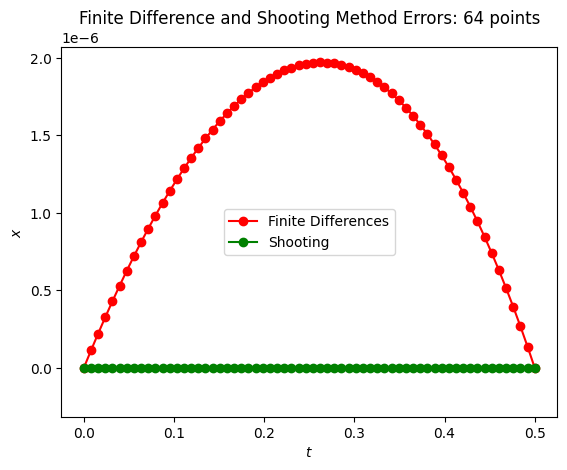

In [ ]:
#!/usr/bin/env python

"""A variety of methods to solve ODE boundary value problems.

AUTHOR:
    Jonathan Senning <jonathan.senning@gordon.edu>
    Gordon College
    Based Octave functions written in the spring of 1999
    Python version: October-November 2008
"""

import numpy

#-----------------------------------------------------------------------------
def shoot( f, a, b, z1, z2, t, tol ):
    """Implements the shooting method to solve second order BVPs

    USAGE:
        y = shoot(f, a, b, z1, z2, t, tol)

    INPUT:
        f     - function dy/dt = f(y,t).  Since we are solving a second-
                order boundary-value problem that has been transformed
                into a first order system, this function should return a
                1x2 array with the first entry equal to y and the second
                entry equal to y'.
        a     - solution value at the left boundary: a = y(t[0]).
        b     - solution value at the right boundary: b = y(t[n-1]).
        z1    - first initial estimate of y'(t[0]).
        z1    - second initial estimate of y'(t[0]).
        t     - array of n time values to determine y at.
        tol   - allowable tolerance on right boundary: | b - y[n-1] | < tol

    OUTPUT:
        y     - array of solution function values corresponding to the
                values in the supplied array t.

    NOTE:
        This function assumes that the second order BVP has been converted to
        a first order system of two equations.  The secant method is used to
        refine the initial values of y' used for the initial value problems.
    """

    from diffeq import rku4

    max_iter = 25   # Maximum number of shooting iterations

    n = len( t )    # Determine the size of the arrays we will generate

    # Compute solution to first initial value problem (IVP) with y'(a) = z1.
    # Because we are using the secant method to refine our estimates of z =
    # y', we don't really need all the solution of the IVP, just the last
    # point of it -- this is saved in w1.

    y = rku4( f, [a,z1], t )
    w1 = y[n-1,0]

    print ("%2d: z = %10.3e, error = %10.3e" % ( 0, z1, b - w1 ))

    # Begin the main loop.  We will compute the solution of a second IVP and
    # then use the both solutions to refine our estimate of y'(a).  This
    # second solution then replaces the first and a new "second" solution is
    # generated.  This process continues until we either solve the problem to
    # within the specified tolerance or we exceed the maximum number of
    # allowable iterations.

    for i in range( max_iter ):

        # Solve second initial value problem, using y'(a) = z2.  We need to
        # retain the entire solution vector y since if y(t(n)) is close enough
        # to b for us to stop then the first column of y becomes our solution
        # vector.

        y = rku4( f, [a,z2], t )
        w2 = y[n-1,0]

        print ("%2d: z = %10.3e, error = %10.3e" % ( i+1, z2, b - w2 ))

        # Check to see if we are done...

        if abs( b - w2 ) < tol:
            break

        # Compute the new approximations to the initial value of the first
        # derivative.  We compute z2 using a linear fit through (z1,w1) and
        # (z2,w2) where w1 and w2 are the estimates at t=b of the initial
        # value problems solved above with y1'(a) = z1 and y2'(a) = z2.  The
        # new value for z1 is the old value of z2.

        #z1, z2 = ( z2, z1 + ( z2 - z1 ) / ( w2 - w1 ) * ( b - w1 ) )
        z1, z2 = ( z2, z2 + ( z2 - z1 ) / ( w2 - w1 ) * ( b - w2 ) )
        w1 = w2

    # All done.  Check to see if we really solved the problem, and then return
    # the solution.

    if abs( b - w2 ) >= tol:
        print ("\a**** ERROR ****")
        print ("Maximum number of iterations (%d) exceeded" % max_iter)
        print ("Returned values may not have desired accuracy")
        print ("Error estimate of returned solution is %e" % ( b - w2 ))

    return y[:,0]

#-----------------------------------------------------------------------------

def fd( u, v, w, t, a, b ):
    """Implements the finite difference  method to solve linear second order BVPs

    Compute finite difference solution to the BVP

        x'' = u(t) + v(t) x + w(t) x'
        x(t[0]) = a, x(t[n-1]) = b

    t should be passed in as an n element array.   u, v, and w should be
    either n element arrays corresponding to u(t), v(t) and w(t) or
    scalars, in which case an n element array with the given value is
    generated for each of them.

    USAGE:
        x = fd(u, v, w, t, a, b)

    INPUT:
        u,v,w - arrays containing u(t), v(t), and w(t) values.  May be
                specified as Python lists, NumPy arrays, or scalars.  In
                each case they are converted to NumPy arrays.
        t     - array of n time values to determine x at
        a     - solution value at the left boundary: a = x(t[0])
        b     - solution value at the right boundary: b = x(t[n-1])

    OUTPUT:
        x     - array of solution function values corresponding to the
                values in the supplied array t.
    """

    # Get the dimension of t and make sure that t is an n-element vector

    if type( t ) != numpy.ndarray:
        if type( t ) == list:
            t = numpy.array( t )
        else:
            t = numpy.array( [ float( t ) ] )

    n = len( t )

    # Make sure that u, v, and w are either scalars or n-element vectors.
    # If they are scalars then we create vectors with the scalar value in
    # each position.

    if type( u ) == int or type( u ) == float:
        u = numpy.array( [ float( u ) ] * n )

    if type( v ) == int or type( v ) == float:
        v = numpy.array( [ float( v ) ] * n )

    if type( w ) == int or type( w ) == float:
        w = numpy.array( [ float( w ) ] * n )

    # Compute the stepsize.  It is assumed that all elements in t are
    # equally spaced.

    h = t[1] - t[0]

    # Construct tridiagonal system; boundary conditions appear as first and
    # last equations in system.

    A = -( 1.0 + w[1:n] * h / 2.0 )
    A[-1] = 0.0

    C = -( 1.0 - w[0:n-1] * h / 2.0 )
    C[0] = 0.0

    D = 2.0 + h * h * v
    D[0] = D[n-1] = 1.0

    B = - h * h * u
    B[0] = a
    B[n-1] = b

    # Solve tridiagonal system

    for i in range( 1, n ):
        xmult = A[i-1] / D[i-1]
        D[i] = D[i] - xmult * C[i-1]
        B[i] = B[i] - xmult * B[i-1]

    x = numpy.zeros( n )
    x[n-1] = B[n-1] / D[n-1]

    for i in range( n - 2, -1, -1 ):
        x[i] = ( B[i] - C[i] * x[i+1] ) / D[i]

    return x

#-----------------------------------------------------------------------------

if __name__ == "__main__":

    import math
    from pylab import *

    # Solves x'' = x + 4exp(t), x(0)=1, x(1/2) = 2exp(1/2) using both the
    # finite difference method and the shooting method.

    # Set up interval.  We will solve the problem for both n=64 and n=128.

    a = 0.0
    b = 0.5
    n1 = 64
    n2 = 128
    t1 = linspace( a, b, n1 )
    t2 = linspace( a, b, n2 )

    # Compute exact solutions.  The transpose of the solution is taken because
    # both the finite difference function fd() and the shooting method function
    # shoot() return nx1 vectors rather than 1xn vectors.

    def exact(t):
        return exp(t) * ( 1 + 2 * t )

    x1 = exact( t1 )
    x2 = exact( t2 )

    # Compute finite difference solutions

    xfd1 = fd( 4 * exp( t1 ), 1, 0, t1, 1, 2 * exp( 0.5 ) )
    xfd2 = fd( 4 * exp( t2 ), 1, 0, t2, 1, 2 * exp( 0.5 ) )

    # Compute shooting method solutions

    def f(x,t):
        return array( [x[1], x[0]+4*exp(t)] )

    xs1 = shoot( f, exp(a), 2*exp(b), 3.0, 4.0, t1, 1e-5 )
    xs2 = shoot( f, exp(a), 2*exp(b), 3.0, 4.0, t2, 1e-5 )

    # Prepare for display; set interactive mode to true so each plot
    # is shown as it is generated

    interactive( True )

    # Plot solutions

    plot( t1, xfd1, 'ro', t2, xfd2, 'b-' )
    title( 'Finite Difference Method' )
    xlabel( '$t$' )
    ylabel( '$x$' )
    legend( ( '%3d points' % n1, '%3d points' % n2 ), loc='lower right' )
    draw()
    z = input( "Press ENTER to continue..." )

    cla()
    plot( t1, xs1, 'go', t2, xs2, 'b-' )
    title( 'Shooting Method' )
    xlabel( '$t$' )
    ylabel( '$x$' )
    legend( ( '%3d points' % n1, '%3d points' % n2 ), loc='lower right' )
    draw()
    z = input( "Press ENTER to continue..." )

    # Plot errors

    cla()
    plot( t1, xfd1 - x1, 'ro', t2, xfd2 - x2, 'b-' )
    title( 'Finite Difference Errors' )
    xlabel( '$t$' )
    ylabel( '$x$' )
    legend( ( '%3d points' % n1, '%3d points' % n2 ), loc='center' )
    draw()
    z = input( "Press ENTER to continue..." )

    cla()
    plot( t1, xs1 - x1, 'go', t2, xs2 - x2, 'b-' )
    title( 'Shooting Method Errors' )
    xlabel( '$t$' )
    ylabel( '$x$' )
    legend( ( '%3d points' % n1, '%3d points' % n2 ), loc='center' )
    draw()
    z = input( "Press ENTER to continue..." )

    cla()
    plot( t1, xfd1 - x1, 'ro-', t1, xs1 - x1, 'go-' )
    # fiddle with ymin value so that shooting method error is not at
    # bottom of window
    win = list( axis() )
    win[2] = win[2] - 0.1 * ( win[3] - win[2] )
    axis( tuple( win ) )
    title( 'Finite Difference and Shooting Method Errors: %d points' % n1 )
    xlabel( '$t$' )
    ylabel( '$x$' )
    legend( ( 'Finite Differences', 'Shooting' ), loc='center' )
    draw()
    z = input( "Press ENTER to quit..." )
